In [ ]:
# Step 1: Download the dataset (LineMOD)
# Download LineMOD dataset
!mkdir -p datasets/linemod/
%cd datasets/linemod/


**Use the cell below to import dataset or use google drive**

In [ ]:
# Download DenseFusion Folder (Which includes a portion of the LimeMOD dataset)

import gdown

# Download DenseFusion Folder (Which includes a portion of the LimeMOD dataset)

!gdown --fuzzy https://drive.google.com/file/d/1qQ8ZjUI6QauzFsiF8EpaaI2nKFWna_kQ/view?usp=sharing -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip



Streaming output truncated to the last 5000 lines.
  inflating: Linemod_preprocessed/segnet_results/11_label/0206_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0207_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0208_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0209_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0210_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0211_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0212_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0213_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0214_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0215_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0216_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0218_label.png  
  inflating: Linemod_preprocessed/segnet_results/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
from google.colab import drive
import shutil
import os

# Define Paths
drive_path = '/content/drive/MyDrive/Linemod_preprocessed.zip'
colab_path = '/content/Linemod_preprocessed.zip'

# Copy file from Drive to Colab Local Runtime
if os.path.exists(drive_path):
    print(f"Found file at {drive_path}. Copying to local runtime...")
    shutil.copy(drive_path, colab_path)
    print("Copy complete!")

    # 4. Unzip
    print("Unzipping dataset...")
    !unzip -q {colab_path}
    print("Unzip complete! Dataset is ready.")
else:
    print(f"Error: Could not find '{drive_path}'.")

In [ ]:
! pip install pcl

In [ ]:
import os
import yaml
import torch
#import open3d as o3d
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [ ]:
! pip install trimesh

In [ ]:
def get_diameter(class_id, models_info):
    # Try integer key first, then string
    info = models_info.get(class_id) or models_info.get(str(class_id))
    if info:
        return info['diameter']
    else:
        return None

In [ ]:
import os
import yaml
import numpy as np
import trimesh
from scipy.spatial import cKDTree # Efficient Nearest Neighbor for full resolution
MODELS_INFO_PATH = 'datasets/linemod/Linemod_preprocessed/models/models_info.yml'

class PoseEvaluator:
    def __init__(self):

        # DEFINE SYMMETRIC OBJECTS
        # ID 10: Eggbox, ID 11: Glue
        self.symmetric_ids = [10, 11]

        # DATA CONTAINERS
        self.diameters = {}
        self.meshes = {}

        self.load_metadata()
        self.load_meshes()

    def load_metadata(self):

        if not os.path.exists(MODELS_INFO_PATH):
            raise FileNotFoundError(f"CRITICAL: Metadata not found at {MODELS_INFO_PATH}")

        with open(MODELS_INFO_PATH, 'r') as f:
            models_info = yaml.safe_load(f)

        target_ids = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]

        for obj_id in target_ids:
            # Handle string/int key mismatch
            real_diameter = get_diameter(obj_id, models_info)
            if real_diameter:
                # Convert mm -> meters
                self.diameters[obj_id] = real_diameter

    def load_meshes(self):
        MODELS_PATH = 'datasets/linemod/Linemod_preprocessed/models/'

        for obj_id in self.diameters.keys():
            filename = f"obj_{obj_id:02d}.ply"
            ply_path = os.path.join(MODELS_PATH, filename)

            if not os.path.exists(ply_path):
                print(f"WARNING: Mesh not found at {ply_path}")
                continue

            mesh = trimesh.load(ply_path)
            vertices = mesh.vertices

            self.meshes[obj_id] = vertices

            print(f"Loaded Object {obj_id}: {len(vertices)} vertices")

    def compute_add_metric(self, pred_R, pred_t, gt_R, gt_t, model_points):
        """
        ADD: Average Distance of Model Points (Asymmetric).
        """
        model_points_m = model_points / 1000.0
        # Transform points
        pred_points = (np.dot(model_points_m, pred_R.T) + pred_t)
        gt_points = (np.dot(model_points_m, gt_R.T) + gt_t)

        # Calculate norm along axis 1
        distances = np.linalg.norm(pred_points - gt_points, axis=1)
        return np.mean(distances)

    def compute_adds_metric(self, pred_R, pred_t, gt_R, gt_t, model_points):
        """
        ADD-S: Average Distance with Symmetry (Symmetric).
        Uses cKDTree for memory-efficient Nearest Neighbor on full point clouds.
        """
        model_points_m = model_points / 1000.0
        pred_points = (np.dot(model_points_m, pred_R.T) + pred_t)
        gt_points = (np.dot(model_points_m, gt_R.T) + gt_t)

        # Build KDTree on Ground Truth points (fast lookup structure).
        kdtree = cKDTree(gt_points)

        # Query: For every predicted point, find the distance to the nearest GT point
        # k=1 -> find the single closest neighbor
        distances, _ = kdtree.query(pred_points, k=1)

        return np.mean(distances)

    def evaluate_single(self, obj_id, pred_R, pred_t, gt_R, gt_t):
        if obj_id not in self.meshes:
            raise ValueError(f"Object {obj_id} not loaded.")

        model_points = self.meshes[obj_id]

        diameter = self.diameters[obj_id]
        diameter_m = diameter / 1000.0  # Convert mm to meters

        if obj_id in self.symmetric_ids:
            error_m = self.compute_adds_metric(pred_R, pred_t, gt_R, gt_t, model_points)
            metric_type = "ADD-S (Full)"
        else:
            error_m = self.compute_add_metric(pred_R, pred_t, gt_R, gt_t, model_points)
            metric_type = "ADD (Full)"

        # Thresholds
        passed_10pct = 1 if (error_m < 0.1 * diameter_m) else 0
        passed_2cm = 1 if (error_m < 0.02) else 0

        # Debug components
        R_diff = np.dot(pred_R, gt_R.T)
        trace = np.trace(R_diff)
        trace = np.clip((trace - 1) / 2, -1.0, 1.0)
        r_err_deg = np.degrees(np.arccos(trace))
        t_err_m = np.linalg.norm(pred_t - gt_t)

        return {
            "obj_id": obj_id,
            "error_m": error_m,
            "metric_type": metric_type,
            "passed_0.1d": passed_10pct,
            "passed_2cm": passed_2cm,
            "R_err": r_err_deg,
            "T_err": t_err_m
        }


In [ ]:
! pip install pandas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class RGBDFusionNet(nn.Module):
    def __init__(self, use_metadata=True):
        super(RGBDFusionNet, self).__init__()
        self.use_metadata = use_metadata

        # 1. RGB Branch (Feature Extractor) -> ResNet50

        original_resnet = models.resnet50(pretrained=True)
        self.rgb_encoder = nn.Sequential(*list(original_resnet.children())[:-2])

        # Freeze early layers
        for param in self.rgb_encoder[0].parameters():
            param.requires_grad = False

        # Projection Layer (2048 -> 512)
        self.rgb_projector = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # 2. Depth Branch (Geometric Extractor)

        self.depth_encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # 3. Fusion Block

        self.fusion_conv = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # 4. Prediction Heads

        feature_dim = 512 + (8 if use_metadata else 0)

        # Output size is now 1 (Tz only) instead of 3
        self.trans_head = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)  # Predicts Depth (Z) only
        )

        self.rot_head = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4)
        )

    def forward(self, rgb, depth, meta=None):
        # 1. Feature Extraction
        f_rgb_raw = self.rgb_encoder(rgb)     # (B, 2048, 7, 7)
        f_depth = self.depth_encoder(depth)   # (B, 512, 7, 7)

        # 2. Projection
        f_rgb = self.rgb_projector(f_rgb_raw) # (B, 512, 7, 7)

        # 3. Fusion
        f_cat = torch.cat([f_rgb, f_depth], dim=1)
        f_fused = self.fusion_conv(f_cat)
        f_flat = f_fused.view(f_fused.size(0), -1)

        # 4. Metadata Injection
        if self.use_metadata and meta is not None:
            if torch.isnan(meta).any():
                raise ValueError("NaN detected in metadata input")
            combined_features = torch.cat([f_flat, meta], dim=1)
        else:
            combined_features = f_flat

        # 5. Prediction (Rotation)
        pred_rot = F.normalize(self.rot_head(combined_features), p=2, dim=1)

        # 6. Prediction (Translation - Pinhole Logic)
        # Predict Tz and calculate Tx, Ty
        pred_tz = self.trans_head(combined_features) # (B, 1)

        if self.use_metadata and meta is not None:
            # meta columns:
            # 0:x, 1:y, 2:w, 3:h, 4:fx, 5:fy, 6:cx, 7:cy (All Normalized)

            # Extract parameters (unsqueeze to keep Batch dim)
            b_x = meta[:, 0].unsqueeze(1)
            b_y = meta[:, 1].unsqueeze(1)
            b_w = meta[:, 2].unsqueeze(1)
            b_h = meta[:, 3].unsqueeze(1)
            fx  = meta[:, 4].unsqueeze(1)
            fy  = meta[:, 5].unsqueeze(1)
            cx  = meta[:, 6].unsqueeze(1)
            cy  = meta[:, 7].unsqueeze(1)

            # Calculate Center of BBox (u, v)
            # Since x and w are both normalized by W_orig, we can add them directly.
            u_cen = b_x + (b_w / 2.0)
            v_cen = b_y + (b_h / 2.0)

            # Calculate X = (u - cx) * Z / fx
            # Calculate Y = (u - cy) * Z / fy

            # Add epsilon to fx/fy to prevent division by zero (stability)
            pred_tx = (u_cen - cx) * pred_tz / (fx + 1e-6)
            pred_ty = (v_cen - cy) * pred_tz / (fy + 1e-6)

            # Concatenate to form full translation vector
            pred_trans = torch.cat([pred_tx, pred_ty, pred_tz], dim=1)

        else:
            pred_trans = torch.cat([torch.zeros_like(pred_tz), torch.zeros_like(pred_tz), pred_tz], dim=1)

        return pred_trans, pred_rot

In [ ]:
# Convert  YOLO results to Absolute Pixel Coordinates and save as YAML
import os
import yaml
import glob
from pathlib import Path
from tqdm import tqdm

INPUT_BASE_DIR = 'results/yolo_results/predictions/predictions_test_set_60-20-20_epc50/'
OUTPUT_FILENAME = 'yolo.yml'

# Image Dimensions for LineMod (Standard)
IMG_WIDTH = 640
IMG_HEIGHT = 480

# 1. ID MAPPING SETUP
LINEMOD_ID_MAP = {
    '01': 'ape', '02': 'benchvise', '04': 'cam', '05': 'can',
    '06': 'cat', '08': 'driller', '09': 'duck', '10': 'eggbox',
    '11': 'glue', '12': 'holepuncher', '13': 'iron', '14': 'lamp', '15': 'phone'
}

# Class Index 0 -> LineMod ID 1, Class Index 2 -> LineMod ID 4, etc.
sorted_keys = sorted(LINEMOD_ID_MAP.keys())
YOLO_TO_LINEMOD = {i: int(k) for i, k in enumerate(sorted_keys)}

# 2. YAML FORMATTER CLASS
class FlowList(list):
    pass

def flow_list_representer(dumper, data):
    return dumper.represent_sequence(u'tag:yaml.org,2002:seq', data, flow_style=True)

yaml.add_representer(FlowList, flow_list_representer)

# 3. MAIN PROCESSING
def parse_yolo_to_yaml():
    if not os.path.exists(INPUT_BASE_DIR):
        print(f"Error: Directory {INPUT_BASE_DIR} does not exist.")
        return

    obj_folders = sorted([
        f for f in os.listdir(INPUT_BASE_DIR)
        if os.path.isdir(os.path.join(INPUT_BASE_DIR, f))
    ])

    print(f"Converting YOLO results to Absolute Pixel Coordinates (640x480)...")

    for folder_name in tqdm(obj_folders, desc="Processing Folders"):
        folder_path = os.path.join(INPUT_BASE_DIR, folder_name)
        folder_data = {}

        txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

        for txt_file in txt_files:
            try:
                frame_id = int(Path(txt_file).stem) # 0000 -> 0
            except ValueError:
                continue

            with open(txt_file, 'r') as f:
                lines = f.readlines()

            detections = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue

                # 1. Parse Normalized Data
                cls_idx = int(parts[0])
                x_norm = float(parts[1])
                y_norm = float(parts[2])
                w_norm = float(parts[3])
                h_norm = float(parts[4])
                conf = float(parts[5])

                # 2. Convert to Absolute Pixel Coordinates
                x_center = x_norm * IMG_WIDTH
                y_center = y_norm * IMG_HEIGHT
                w_abs = w_norm * IMG_WIDTH
                h_abs = h_norm * IMG_HEIGHT
                x_top_left = x_center - (w_abs / 2)
                y_top_left = y_center - (h_abs / 2)


                # 3. Handle ID Mapping
                if cls_idx in YOLO_TO_LINEMOD:
                    real_obj_id = YOLO_TO_LINEMOD[cls_idx]
                else:
                    continue

                # 4. Create Entry
                # obj_bb gets FlowList for [x, y, w, h] style
                # confidence is separate
                bbox_data = FlowList([
                    round(x_top_left, 4),
                    round(y_top_left, 4),
                    round(w_abs, 4),
                    round(h_abs, 4)
                ])

                detections.append({
                    'obj_id': real_obj_id,
                    'obj_bb': bbox_data,
                    'confidence': round(conf, 6)
                })

            if detections:
                folder_data[frame_id] = detections

        # Save to YAML
        output_path = os.path.join(folder_path, OUTPUT_FILENAME)
        with open(output_path, 'w') as f_out:
            yaml.dump(folder_data, f_out, sort_keys=True)

    print(f"✅ Conversion Complete. Results in {OUTPUT_FILENAME}")

if __name__ == "__main__":
    parse_yolo_to_yaml()

Converting YOLO results to Absolute Pixel Coordinates (640x480)...


Processing Folders: 100%|██████████| 13/13 [00:47<00:00,  3.69s/it]

✅ Conversion Complete. Results in yolo.yml


In [ ]:
import os
import yaml
import torch
import cv2
import numpy as np
import pickle
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

class ExtensionDataset(Dataset):

    def __init__(self, root_dir, split_file, img_size=224, use_yolo_boxes=False, force_reprocess=False):
        """
        Args:
            root_dir (str): Path to dataset root.
            split_file (str): Path to 'train.txt' or 'test.txt'.
            img_size (int): Target size.
            use_yolo_boxes (bool): If True, loads bbox from 'yolo.yml'.
            force_reprocess (bool): Set True to ignore cache.
        """

        self.root_dir = root_dir
        self.img_size = img_size
        self.data_path = os.path.join(root_dir, 'data')
        self.use_yolo_boxes = use_yolo_boxes
        self.samples = []

        # Path to YOLO results
        self.yolo_root = "results/yolo_results/predictions/predictions_test_set_60-20-20_epc50/"

        # Define cache path
        split_name = os.path.splitext(os.path.basename(split_file))[0]
        mode_suffix = "_yolo" if use_yolo_boxes else "_gt"
        cache_filename = f"{split_name}{mode_suffix}_metadata_cache.pkl"
        cache_path = os.path.join(root_dir, cache_filename)


        if os.path.exists(cache_path) and not force_reprocess:
            print(f"[{split_name}] Found cache at {cache_path}. Loading fast...")
            with open(cache_path, 'rb') as f:
                self.samples = pickle.load(f)
            print(f"[{split_name}] Loaded {len(self.samples)} samples (YOLO={use_yolo_boxes}).")
        else:
            print(f"[{split_name}] No cache found. Processing metadata (YOLO={use_yolo_boxes})...")
            self._process_and_cache(split_file, cache_path)

        # ImageNet normalization
        self.rgb_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def _process_and_cache(self, split_file, cache_path):
        with open(split_file, 'r') as f:
            file_paths = [line.strip() for line in f.readlines() if line.strip()]

        meta_cache = {}
        yolo_cache = {}

        for path in tqdm(file_paths, desc="Parsing Metadata"):
            norm_path = os.path.normpath(path)
            parts = norm_path.split(os.sep)
            if len(parts) < 2: parts = path.split('/')
            if len(parts) < 2: parts = path.split('\\')

            try:
                if 'data' in parts:
                    data_idx = parts.index('data')
                    obj_id = parts[data_idx + 1]
                    img_filename = parts[-1]
                else:
                    obj_id = parts[0]
                    img_filename = parts[-1]

                img_id_str = os.path.splitext(img_filename)[0]
                img_id_int = int(img_id_str)
            except (ValueError, IndexError):
                continue

            if obj_id not in meta_cache:
                obj_folder = os.path.join(self.data_path, obj_id)
                if not os.path.exists(obj_folder): continue

                gt_path = os.path.join(obj_folder, 'gt.yml')
                info_path = os.path.join(obj_folder, 'info.yml')

                def load_yaml(p):
                    with open(p, 'r') as f:
                        if hasattr(yaml, 'CLoader'): return yaml.load(f, Loader=yaml.CLoader)
                        return yaml.safe_load(f)

                meta_cache[obj_id] = {'gt': load_yaml(gt_path), 'info': load_yaml(info_path)}

                if self.use_yolo_boxes:
                    y_path = os.path.join(self.yolo_root, obj_id, 'yolo.yml')
                    if os.path.exists(y_path):
                        yolo_cache[obj_id] = load_yaml(y_path)
                    else:
                        yolo_cache[obj_id] = {}

            gt_data = meta_cache[obj_id]['gt']
            info_data = meta_cache[obj_id]['info']

            if img_id_int not in gt_data: continue

            gt_list = gt_data[img_id_int]
            valid_gt_entry = None

            for entry in gt_list:
                if int(entry['obj_id']) == int(obj_id):
                    valid_gt_entry = entry
                    break

            if obj_id == '02' and valid_gt_entry is None: continue
            if valid_gt_entry is None: valid_gt_entry = gt_list[0]

            final_bbox = None
            if self.use_yolo_boxes:
                if obj_id in yolo_cache and img_id_int in yolo_cache[obj_id]:
                    preds = yolo_cache[obj_id][img_id_int]
                    if preds and len(preds) > 0:
                        final_bbox = preds[0]['obj_bb']
                if final_bbox is None: continue
            else:
                final_bbox = valid_gt_entry['obj_bb']

            self.samples.append({
                'obj_id': obj_id,
                'img_id': img_id_str,
                'bbox': final_bbox,
                'cam_t_m2c': valid_gt_entry['cam_t_m2c'],
                'cam_R_m2c': valid_gt_entry['cam_R_m2c'],
                'cam_K': info_data[img_id_int]['cam_K'],
                'depth_scale': info_data[img_id_int]['depth_scale']
            })

        print(f"Saving processed metadata to {cache_path}...")
        with open(cache_path, 'wb') as f:
            pickle.dump(self.samples, f)
        print("Done.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        obj_id = sample['obj_id']
        img_id = sample['img_id']

        rgb_path = os.path.join(self.data_path, obj_id, 'rgb', f"{img_id}.png")
        depth_path = os.path.join(self.data_path, obj_id, 'depth', f"{img_id}.png")

        # Load Images
        rgb_img = cv2.imread(rgb_path)
        if rgb_img is None:
             rgb_img = np.zeros((480, 640, 3), dtype=np.uint8)
        else:
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth_img is None:
            depth_img = np.zeros((480, 640), dtype=np.float32)
        else:
            depth_img = depth_img.astype(np.float32)

        depth_scale = sample['depth_scale']
        depth_img = depth_img * depth_scale / 1000.0

        # Parse Metadata
        bbox = sample['bbox']
        x, y, w, h = map(int, bbox)

        k_flat = sample['cam_K']
        fx, cx, fy, cy = k_flat[0], k_flat[2], k_flat[4], k_flat[5]

        #Crop & Resize
        H_orig, W_orig, _ = rgb_img.shape

        # Normalize bbox and intrinsics by the ORIGINAL image size
        meta_vector = torch.tensor([
            x / W_orig,      # Normalized x
            y / H_orig,      # Normalized y
            w / W_orig,      # Normalized w
            h / H_orig,      # Normalized h
            fx / W_orig,     # Normalized fx
            fy / H_orig,     # Normalized fy
            cx / W_orig,     # Normalized cx
            cy / H_orig      # Normalized cy
        ], dtype=torch.float32)

        x1 = max(0, x)
        y1 = max(0, y)
        x2 = min(W_orig, x + w)
        y2 = min(H_orig, y + h)

        if x2 <= x1 or y2 <= y1:
            rgb_crop = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            depth_crop = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        else:
            rgb_crop = rgb_img[y1:y2, x1:x2]
            depth_crop = depth_img[y1:y2, x1:x2]

            rgb_crop = cv2.resize(rgb_crop, (self.img_size, self.img_size))
            depth_crop = cv2.resize(depth_crop, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        rgb_tensor = self.rgb_transform(rgb_crop)
        depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0)

        # Ground Truth Pose
        gt_t = torch.tensor(sample['cam_t_m2c'], dtype=torch.float32)
        gt_t_meters = gt_t / 1000.0

        cam_R_m2c = np.array(sample['cam_R_m2c']).reshape(3, 3)

        gt_R = R.from_matrix(cam_R_m2c).as_quat()

        return {
            'rgb_crop': rgb_tensor,
            'depth_crop': depth_tensor,
            'meta_vector': meta_vector, # Now ranges approx 0.0 to 1.0 thanks to normalization
            'gt_t': gt_t_meters,
            'gt_R': gt_R,
            'obj_id': int(obj_id)
        }

In [ ]:
ext_train_dataset = ExtensionDataset(root_dir='datasets/linemod/Linemod_preprocessed', split_file='train.txt', use_yolo_boxes=False)
ext_train_loader = DataLoader(ext_train_dataset, batch_size=16, shuffle=True, pin_memory=True)
ext_val_dataset = ExtensionDataset(root_dir='datasets/linemod/Linemod_preprocessed', split_file='val.txt', use_yolo_boxes=False)
ext_val_loader = DataLoader(ext_val_dataset, batch_size=16, shuffle=False, pin_memory=True)
ext_test_dataset = ExtensionDataset(root_dir='datasets/linemod/Linemod_preprocessed', split_file='test.txt')
ext_test_loader = DataLoader(ext_test_dataset, batch_size=16, shuffle=False, pin_memory=True)

[train] No cache found. Processing metadata (YOLO=False)...


Parsing Metadata:   0%|          | 0/9480 [00:00<?, ?it/s]

Parsing Metadata: 100%|██████████| 9480/9480 [00:05<00:00, 1619.75it/s]


Saving processed metadata to datasets/linemod/Linemod_preprocessed\train_gt_metadata_cache.pkl...
Done.
[val] No cache found. Processing metadata (YOLO=False)...


Parsing Metadata: 100%|██████████| 3160/3160 [00:05<00:00, 608.60it/s]


Saving processed metadata to datasets/linemod/Linemod_preprocessed\val_gt_metadata_cache.pkl...
Done.
[test] No cache found. Processing metadata (YOLO=False)...


Parsing Metadata: 100%|██████████| 3160/3160 [00:05<00:00, 577.57it/s]

Saving processed metadata to datasets/linemod/Linemod_preprocessed\test_gt_metadata_cache.pkl...
Done.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import time
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn

class PoseLoss(nn.Module):
    def __init__(self, w_trans=10.0, w_rot=1.0):
        """
        Args:
            w_trans: Weight for translation loss.
                     (Suggest 10.0 because meters are small: 0.02m error is tiny numerically)
            w_rot: Weight for rotation loss.
        """
        super(PoseLoss, self).__init__()
        self.w_trans = w_trans
        self.w_rot = w_rot
        self.trans_loss = nn.L1Loss() # L1 is often sharper than SmoothL1 for final convergence

    def forward(self, pred_t, pred_q, gt_t, gt_q):
        """
        pred_t: (B, 3) Predicted Translation (Meters)
        pred_q: (B, 4) Predicted Quaternion (Normalized)
        gt_t:   (B, 3) Ground Truth Translation (Meters)
        gt_q:   (B, 4) Ground Truth Quaternion (from Dataset)
        """

        # 1. Translation Loss
        loss_t = self.trans_loss(pred_t, gt_t)

        # 2. Rotation Loss

        # Quaternion Distance: 1 - |<q1, q2>|
        # We use abs() because q and -q represent the same rotation.
        dot_prod = torch.sum(pred_q * gt_q, dim=1)
        loss_r = 1.0 - torch.mean(torch.abs(dot_prod))

        # 3. Combined Loss
        total_loss = (self.w_trans * loss_t) + (self.w_rot * loss_r)

        return total_loss, loss_t.item(), loss_r.item()

In [ ]:
import torch
print(f"Is CUDA available? : {torch.cuda.is_available()}")
print(f"PyTorch Version    : {torch.version.__version__}")
print(f"CUDA Version       : {torch.version.cuda}")

Is CUDA available? : True
PyTorch Version    : 2.9.1+cu130
CUDA Version       : 13.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

class RGBDTrainer:
    def __init__(self, model, train_loader, val_loader, device, lr=0.00001):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)

        # Schedular for dynamic Learning Rate
        # Reduce LR by factor of 0.1 if validation loss doesn't improve for 3 epochs
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.1,
            patience=3,
        )

        # Loss Function
        self.criterion = PoseLoss(w_trans=15.0, w_rot=1.0)

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_loss_t': [],
            'train_loss_r': [],
            'lr': [] # Track LR changes
        }

        os.makedirs("results/extension_results", exist_ok=True)

    def train_epoch(self, epoch_idx):
        self.model.train()
        running_loss = 0.0
        running_t = 0.0
        running_r = 0.0

        pbar = tqdm(self.train_loader, desc=f"  Train Ep {epoch_idx+1}", leave=False)

        for batch in pbar:
            rgb = batch['rgb_crop'].to(self.device)
            depth = batch['depth_crop'].to(self.device)
            meta = batch['meta_vector'].to(self.device)

            gt_t = batch['gt_t'].to(self.device)
            gt_q = batch['gt_R'].to(self.device).float()

            self.optimizer.zero_grad()
            pred_t, pred_q = self.model(rgb, depth, meta)

            loss, l_t, l_r = self.criterion(pred_t, pred_q, gt_t, gt_q)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            running_t += l_t
            running_r += l_r

            pbar.set_postfix({'L_Trans': f"{l_t:.4f}", 'L_Rot': f"{l_r:.4f}"})

        avg_loss = running_loss / len(self.train_loader)
        avg_t = running_t / len(self.train_loader)
        avg_r = running_r / len(self.train_loader)

        return avg_loss, avg_t, avg_r

    def validate(self):
        self.model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in self.val_loader:
                rgb = batch['rgb_crop'].to(self.device)
                depth = batch['depth_crop'].to(self.device)
                meta = batch['meta_vector'].to(self.device)

                gt_t = batch['gt_t'].to(self.device)
                gt_q = batch['gt_R'].to(self.device).float()

                pred_t, pred_q = self.model(rgb, depth, meta)
                loss, _, _ = self.criterion(pred_t, pred_q, gt_t, gt_q)

                val_loss += loss.item()

        return val_loss / len(self.val_loader)

    def run(self, epochs=30):
        print(f"Starting training on {self.device}...")
        best_loss = float('inf')

        epoch_pbar = tqdm(range(epochs), desc="Overall Progress", position=0)

        for epoch in epoch_pbar:
            # 1. Train
            t_loss, t_loss_t, t_loss_r = self.train_epoch(epoch)

            # 2. Validate
            v_loss = self.validate()

            # 3. Step Scheduler (Monitor Val Loss)
            self.scheduler.step(v_loss)

            # Record current LR
            current_lr = self.optimizer.param_groups[0]['lr']
            self.history['lr'].append(current_lr)

            # 4. Save Metrics
            self.history['train_loss'].append(t_loss)
            self.history['val_loss'].append(v_loss)
            self.history['train_loss_t'].append(t_loss_t)
            self.history['train_loss_r'].append(t_loss_r)

            epoch_pbar.write(f"Ep {epoch+1} | Train: {t_loss:.4f} | Val: {v_loss:.4f} | LR: {current_lr:.2e}")

            # Save Checkpoint
            if v_loss < best_loss:
                best_loss = v_loss
                torch.save(self.model.state_dict(), "results/extension_results/best_rgbd_model.pth")
                epoch_pbar.write(f"  >>> New Best Saved! ({best_loss:.4f})")

        return self.history

In [ ]:
import pickle

# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Setup Model (Use the RGBDFusionNet class)
try:
    model = RGBDFusionNet()
    print("Loaded RGBDFusionNet")
except NameError:
    print("ERROR: RGBDFusionNet class not found. Please define the model class first.")
    raise

# 3. Train
trainer = RGBDTrainer(model, ext_train_loader, ext_val_loader, device)
print("Loaded Trainer. Starting Training...")

# Run for 30 epochs
history = trainer.run(epochs=30)

# 4. Save History
with open('results/extension_results/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("History saved to results/extension_results/training_history.pkl")

Using device: cuda


c:\Users\kraka\Desktop\Can\AML\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kraka\Desktop\Can\AML\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded RGBDFusionNet
Loaded Trainer. Starting Training...
Starting training on cuda...


Overall Progress:   0%|          | 0/30 [07:20<?, ?it/s]

Ep 1 | Train: 1.1191 | Val: 0.3829 | LR: 1.00e-05


Overall Progress:   3%|▎         | 1/30 [07:21<3:33:11, 441.10s/it]

  >>> New Best Saved! (0.3829)


Overall Progress:   7%|▋         | 2/30 [12:18<2:46:25, 356.63s/it]

Ep 2 | Train: 0.5125 | Val: 0.2980 | LR: 1.00e-05
  >>> New Best Saved! (0.2980)


Overall Progress:  10%|█         | 3/30 [17:15<2:28:07, 329.18s/it]

Ep 3 | Train: 0.4515 | Val: 0.2924 | LR: 1.00e-05
  >>> New Best Saved! (0.2924)


Overall Progress:  13%|█▎        | 4/30 [21:32<2:10:24, 300.93s/it]

Ep 4 | Train: 0.4058 | Val: 0.2351 | LR: 1.00e-05
  >>> New Best Saved! (0.2351)


Overall Progress:  17%|█▋        | 5/30 [25:53<1:59:20, 286.41s/it]

Ep 5 | Train: 0.3919 | Val: 0.2271 | LR: 1.00e-05
  >>> New Best Saved! (0.2271)


Overall Progress:  20%|██        | 6/30 [30:36<1:54:03, 285.16s/it]

Ep 6 | Train: 0.3757 | Val: 0.2511 | LR: 1.00e-05


Overall Progress:  20%|██        | 6/30 [35:29<1:54:03, 285.16s/it]

Ep 7 | Train: 0.3725 | Val: 0.2034 | LR: 1.00e-05


Overall Progress:  23%|██▎       | 7/30 [35:29<1:50:19, 287.83s/it]

  >>> New Best Saved! (0.2034)


Overall Progress:  27%|██▋       | 8/30 [40:25<1:46:26, 290.31s/it]

Ep 8 | Train: 0.3627 | Val: 0.2036 | LR: 1.00e-05


Overall Progress:  30%|███       | 9/30 [45:18<1:41:59, 291.43s/it]

Ep 9 | Train: 0.3560 | Val: 0.1917 | LR: 1.00e-05
  >>> New Best Saved! (0.1917)


Overall Progress:  33%|███▎      | 10/30 [50:13<1:37:26, 292.33s/it]

Ep 10 | Train: 0.3418 | Val: 0.1825 | LR: 1.00e-05
  >>> New Best Saved! (0.1825)


Overall Progress:  37%|███▋      | 11/30 [55:06<1:32:41, 292.69s/it]

Ep 11 | Train: 0.3460 | Val: 0.2184 | LR: 1.00e-05


Overall Progress:  40%|████      | 12/30 [1:00:00<1:27:52, 292.94s/it]

Ep 12 | Train: 0.3467 | Val: 0.1698 | LR: 1.00e-05
  >>> New Best Saved! (0.1698)


Overall Progress:  43%|████▎     | 13/30 [1:04:55<1:23:13, 293.75s/it]

Ep 13 | Train: 0.3404 | Val: 0.1978 | LR: 1.00e-05


Overall Progress:  47%|████▋     | 14/30 [1:09:53<1:18:38, 294.91s/it]

Ep 14 | Train: 0.3344 | Val: 0.1973 | LR: 1.00e-05


Overall Progress:  50%|█████     | 15/30 [1:14:09<1:10:47, 283.17s/it]

Ep 15 | Train: 0.3211 | Val: 0.1834 | LR: 1.00e-05


Overall Progress:  53%|█████▎    | 16/30 [1:19:03<1:06:49, 286.39s/it]

Ep 16 | Train: 0.3320 | Val: 0.1796 | LR: 1.00e-06


Overall Progress:  53%|█████▎    | 16/30 [1:23:56<1:06:49, 286.39s/it]

Ep 17 | Train: 0.3230 | Val: 0.1505 | LR: 1.00e-06
  >>> New Best Saved! (0.1505)


Overall Progress:  60%|██████    | 18/30 [1:28:49<57:58, 289.88s/it]  

Ep 18 | Train: 0.3195 | Val: 0.1520 | LR: 1.00e-06


Overall Progress:  63%|██████▎   | 19/30 [1:33:44<53:23, 291.19s/it]

Ep 19 | Train: 0.3188 | Val: 0.1542 | LR: 1.00e-06


Overall Progress:  67%|██████▋   | 20/30 [1:38:27<48:09, 288.99s/it]

Ep 20 | Train: 0.3142 | Val: 0.1488 | LR: 1.00e-06
  >>> New Best Saved! (0.1488)


Overall Progress:  70%|███████   | 21/30 [1:42:51<42:11, 281.30s/it]

Ep 21 | Train: 0.3110 | Val: 0.1549 | LR: 1.00e-06


Overall Progress:  70%|███████   | 21/30 [1:47:43<42:11, 281.30s/it]

Ep 22 | Train: 0.3056 | Val: 0.1440 | LR: 1.00e-06


Overall Progress:  73%|███████▎  | 22/30 [1:47:43<37:57, 284.64s/it]

  >>> New Best Saved! (0.1440)


Overall Progress:  77%|███████▋  | 23/30 [1:52:33<33:24, 286.30s/it]

Ep 23 | Train: 0.3089 | Val: 0.1521 | LR: 1.00e-06


Overall Progress:  80%|████████  | 24/30 [1:57:25<28:46, 287.77s/it]

Ep 24 | Train: 0.3159 | Val: 0.1628 | LR: 1.00e-06


Overall Progress:  83%|████████▎ | 25/30 [2:02:14<24:01, 288.23s/it]

Ep 25 | Train: 0.3095 | Val: 0.1419 | LR: 1.00e-06
  >>> New Best Saved! (0.1419)


Overall Progress:  87%|████████▋ | 26/30 [2:06:27<18:30, 277.70s/it]

Ep 26 | Train: 0.3063 | Val: 0.1427 | LR: 1.00e-06


Overall Progress:  87%|████████▋ | 26/30 [2:11:16<18:30, 277.70s/it]

Ep 27 | Train: 0.3058 | Val: 0.1417 | LR: 1.00e-06


Overall Progress:  90%|█████████ | 27/30 [2:11:16<14:03, 281.13s/it]

  >>> New Best Saved! (0.1417)


Overall Progress:  93%|█████████▎| 28/30 [2:15:31<09:06, 273.16s/it]

Ep 28 | Train: 0.3044 | Val: 0.1361 | LR: 1.00e-06
  >>> New Best Saved! (0.1361)


Overall Progress:  97%|█████████▋| 29/30 [2:20:16<04:36, 276.68s/it]

Ep 29 | Train: 0.3070 | Val: 0.1894 | LR: 1.00e-06


Overall Progress: 100%|██████████| 30/30 [2:25:01<00:00, 290.04s/it]

Ep 30 | Train: 0.3032 | Val: 0.1387 | LR: 1.00e-06
History saved to results/extension_results/training_history.pkl


In [ ]:
with open('results/extension_results/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

>>> History loaded successfully!
    Epochs trained: 30
    Metrics available: ['train_loss', 'val_loss', 'train_loss_t', 'train_loss_r', 'lr']


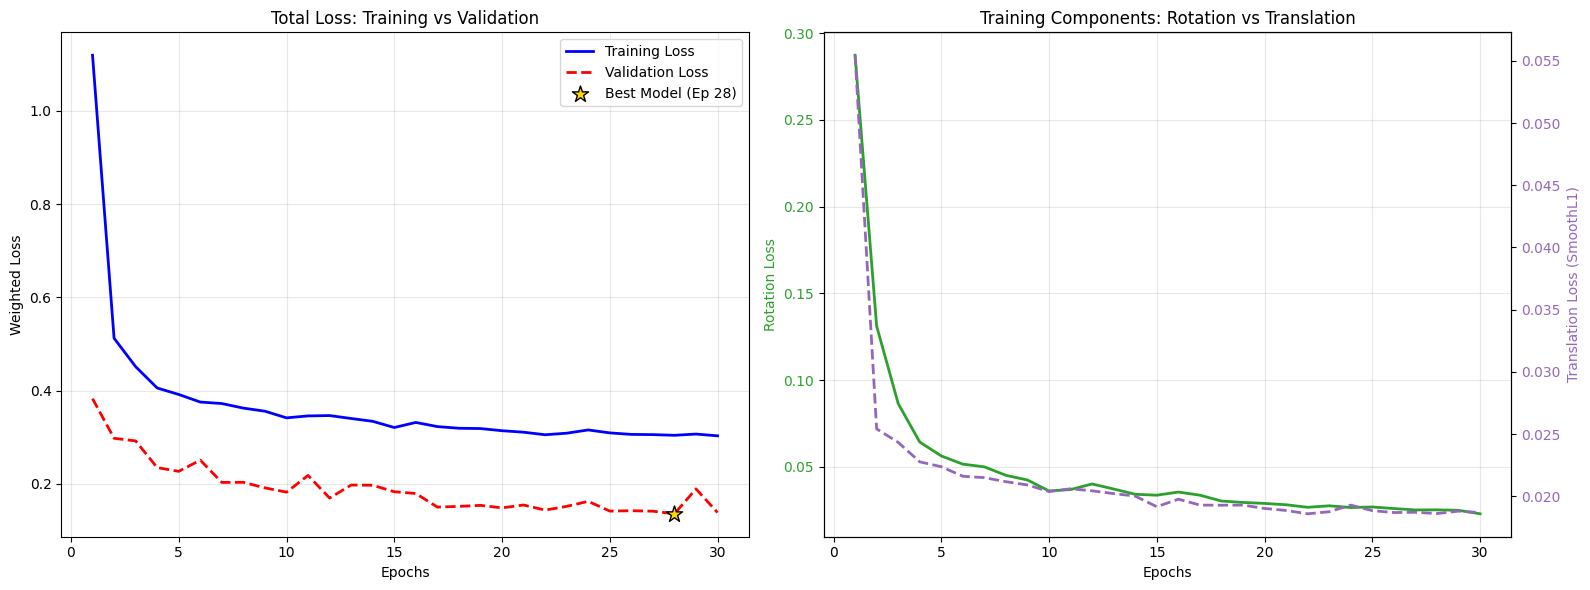

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # PLOT 1: Overall Loss (Train vs Val)
    # This detects Overfitting
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)

    # Mark the best epoch (lowest val loss)
    best_val_idx = np.argmin(history['val_loss'])
    best_val_loss = history['val_loss'][best_val_idx]
    best_epoch = epochs[best_val_idx]

    ax1.scatter(best_epoch, best_val_loss, c='gold', s=150, zorder=5, edgecolors='k', marker='*', label=f'Best Model (Ep {best_epoch})')

    ax1.set_title('Total Loss: Training vs Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Weighted Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # PLOT 2: Component Breakdown (Trans vs Rot)
    # Detect if one task is dominating the gradient

    # Y-Axis 1: Rotation (Green)
    color = 'tab:green'
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Rotation Loss', color=color)
    ax2.plot(epochs, history['train_loss_r'], color=color, label='Rotation', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)

    # Y-Axis 2: Translation (Magenta)
    ax2_twin = ax2.twinx()
    color = 'tab:purple'
    ax2_twin.set_ylabel('Translation Loss (SmoothL1)', color=color)
    ax2_twin.plot(epochs, history['train_loss_t'], color=color, linestyle='--', label='Translation', linewidth=2)
    ax2_twin.tick_params(axis='y', labelcolor=color)

    ax2.set_title('Training Components: Rotation vs Translation')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
# Define history file path
file_path = 'results/extension_results/training_history.pkl'

try:
    with open(file_path, 'rb') as f:
        history = pickle.load(f)

    print(">>> History loaded successfully!")
    print(f"    Epochs trained: {len(history['train_loss'])}")
    print(f"    Metrics available: {list(history.keys())}")

except FileNotFoundError:
    print(f"ERROR: Could not find '{file_path}'. Check your file path.")
    history = None
plot_training_results(history)

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

# --- 1. THE ADAPTER FUNCTION ---
def run_rgbd_evaluation(model, test_loader, evaluator, device):
    """
    Runs evaluation for the RGB-D model.
    Unlike the hybrid baseline, this gets BOTH Translation and Rotation
    directly from the neural network.
    """
    model.eval()
    all_results = []

    print(f"Starting RGB-D Evaluation on {device}...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):

            # 1. Unpack Batch (RGB-D specific keys)
            rgb = batch['rgb_crop'].to(device)
            depth = batch['depth_crop'].to(device)
            meta = batch['meta_vector'].to(device)

            # Ground Truth (Keep on CPU or move to CPU for numpy conversion later)
            gt_t_batch = batch['gt_t'].numpy() # (B, 3)
            gt_R_batch = batch['gt_R'].numpy() # (B, 3, 3)
            obj_ids = batch['obj_id'].numpy()

            # 2. Model Prediction
            # pred_t: (B, 3), pred_q: (B, 4)
            pred_t_tensor, pred_q_tensor = model(rgb, depth, meta)

            # 3. Convert to Numpy
            pred_t_batch = pred_t_tensor.cpu().numpy()
            pred_q_batch = pred_q_tensor.cpu().numpy()

            # 4. Scipy Rotation Conversion (Quaternion -> Matrix)
            try:
                pred_R_batch = R.from_quat(pred_q_batch).as_matrix() # Returns (B, 3, 3)
                gt_R_batch = R.from_quat(gt_R_batch).as_matrix()

            except ValueError:
                # Fallback if batch size is 1 or float issues
                pred_R_batch = np.array([R.from_quat(q).as_matrix() for q in pred_q_batch])
                gt_R_batch = np.array([R.from_quat(q).as_matrix() for q in gt_R_batch])

            # 5. Iterate through batch and Evaluate
            for i in range(len(obj_ids)):
                obj_id = int(obj_ids[i])

                # Check if we have metadata/mesh for this object
                if obj_id not in evaluator.diameters:
                    continue

                # Prepare Single Inputs
                pred_R = pred_R_batch[i] # (3, 3)
                pred_t = pred_t_batch[i] # (3,)
                gt_R   = gt_R_batch[i]   # (3, 3)
                gt_t   = gt_t_batch[i]   # (3,)

                # Orthonormalize Prediction
                u, _, vt = np.linalg.svd(pred_R)
                pred_R_clean = np.dot(u, vt)

                res = evaluator.evaluate_single(
                    obj_id,
                    pred_R_clean,
                    pred_t,
                    gt_R,
                    gt_t
                )

                all_results.append(res)

    print(f"\nEvaluation Complete. Processed {len(all_results)} samples.")
    return all_results

# 2. EXECUTION SCRIPT

# Initialize Evaluator
eval_instance = PoseEvaluator()

model = RGBDFusionNet().to(device)
model.load_state_dict(torch.load("results/extension_results/best_rgbd_model.pth"))
# Run Evaluation
results = run_rgbd_evaluation(model, ext_test_loader, eval_instance, device)


Loaded Object 1: 5841 vertices
Loaded Object 2: 38325 vertices
Loaded Object 4: 18995 vertices
Loaded Object 5: 22831 vertices
Loaded Object 6: 15736 vertices
Loaded Object 8: 12655 vertices
Loaded Object 9: 7912 vertices
Loaded Object 10: 18473 vertices
Loaded Object 11: 7479 vertices
Loaded Object 12: 15972 vertices
Loaded Object 13: 18216 vertices
Loaded Object 14: 24593 vertices
Loaded Object 15: 16559 vertices
Starting RGB-D Evaluation on cuda...


Evaluating: 100%|██████████| 198/198 [02:04<00:00,  1.60it/s]


Evaluation Complete. Processed 3160 samples.


In [ ]:
# --- REPORT GENERATION ---
def generate_report_tables(all_results, evaluator):
    df = pd.DataFrame(all_results)

    print("\n" + "="*85)
    print("="*85)
    print(f"{'Object':<10} | {'Metric':<10} | {'ADD/ADD-S(cm)':<12} |{'ADD(S)@0.1d':<12} | {'ADD(S)@2cm':<12} | {'Rot(°)'} | {'Trans(cm)'}")
    print("-" * 85)

    ids = sorted(df['obj_id'].unique())

    for obj_id in ids:
        subset = df[df['obj_id'] == obj_id]
        metric_used = "ADD-S" if obj_id in evaluator.symmetric_ids else "ADD"

        acc_10pct = subset['passed_0.1d'].mean() * 100
        acc_2cm   = subset['passed_2cm'].mean() * 100
        r_err     = subset['R_err'].mean()
        t_err_m  = subset['T_err'].mean()
        add_err = subset['error_m'].mean() * 100  # Convert m to cm

        print(f"Obj {obj_id:<6} | {metric_used:<10} | {add_err:>10.2f} | {acc_10pct:>10.2f}% | {acc_2cm:>10.2f}%  | {r_err:>6.1f} | {t_err_m * 100:>8.2f}")

    print("-" * 85)
    print(f"{'MEAN':<10} | {'ALL':<10} | {df['error_m'].mean() * 100:>10.2f} | {df['passed_0.1d'].mean()*100:>10.2f}% | {df['passed_2cm'].mean()*100:>10.2f}% | {df['R_err'].mean():>6.1f} | {df['T_err'].mean()*100:>8.2f}")
    print("="*85)

In [ ]:
# D. Generate Report
print("TABLE 2: RGB-D 6D POSE RESULTS (End-to-End)")
generate_report_tables(results, eval_instance)

TABLE 2: RGB-D 6D POSE RESULTS (End-to-End)

Object     | Metric     | ADD/ADD-S(cm) |ADD(S)@0.1d  | ADD(S)@2cm   | Rot(°) | Trans(cm)
-------------------------------------------------------------------------------------
Obj 1      | ADD        |       1.53 |      18.26% |      82.61%  |   17.3 |     1.26
Obj 2      | ADD        |       2.84 |      45.12% |      28.86%  |   18.4 |     2.08
Obj 4      | ADD        |       2.41 |      25.47% |      36.32%  |   16.4 |     1.82
Obj 5      | ADD        |       2.40 |      43.60% |      43.20%  |   19.7 |     1.51
Obj 6      | ADD        |       1.76 |      45.61% |      72.80%  |   16.4 |     1.38
Obj 8      | ADD        |       3.13 |      38.72% |      19.57%  |   21.2 |     2.02
Obj 9      | ADD        |       1.88 |      11.36% |      62.12%  |   18.1 |     1.57
Obj 10     | ADD-S      |       0.67 |     100.00% |     100.00%  |   16.3 |     1.09
Obj 11     | ADD-S      |       0.82 |      98.46% |      99.23%  |   19.0 |     1.36
Obj 1